# 2.3 첫 번째 심층 신경망

## 2.3.1 데이터 적재

In [1]:
import numpy as np
from keras.utils import to_categorical
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

NUM_CLASSES =10

# 기본적으로 이미지 데이터는 픽셀 채널마다 0~255의 정수로 구성된다
# 신경망은 입력이 -1 ~ 1일 때 가장 잘 동작하기 때문에 데이터를 255로 나눈다 (batch normalization)
x_train = x_train.astype('float32')/255.0  # [50000,32,32,3] 크기의 numpy 배열
x_test = x_test.astype('float32')/255.0   # [10000,32,32,3] 크기의 numpy 배열

# y_train, y_test는 이미지의 클래스에 해당하는 0에서 9사이의 정수 레이블을 갖고 있다
# y_train, y_test 크기는 [50000,1] , [10000,1] 크기의 numpy 배열
# 변환된 y_train, y_test는 [50000,10] , [10000,10] 크기 (정수 레이블을 원-핫 인코딩 벡터로 바꾼 것)
y_train = to_categorical(y_train, NUM_CLASSES)  
y_test = to_categorical(y_test,NUM_CLASSES)     

Using TensorFlow backend.
C:\Users\mkflo\.conda\envs\generative\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mkflo\.conda\envs\generative\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mkflo\.conda\envs\generative\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mkflo\.conda\envs\generative\lib

In [2]:
x_train [54,12,13,1]  # 54번 인덱스의 이미지에서 12,13 위치에 해당하는 픽셀의 초록 채널(1)값 

0.36862746

In [3]:
print(len(x_test))
print(len(y_test))

10000
10000


## 2.3.2 모델 만들기

케라스에서 신경망 구조를 정의하는 방법은 두 가지
- Sequential모델 - 일렬로 층을 쌓은 네트워크를 빠르게 만들 때 사용하기 좋음(즉 어떤 분기가 없어 이전 층이 그대로 다음 층으로 연결될 때)
- 함수형 API - 가지가 있는 네트워크를 만들려면 유연성 많은 함수형 API 사용해야함(ex. 한 층의 출력이 여러개의 별도의 층으로 전달 , 한 층이 여러층으로 부터 입력 받음)

In [4]:
# Sequential 모델을 사용한 네트워크

from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential([Dense(200,activation = 'relu', input_shape = (32,32,3)), 
                  Flatten(),
                  Dense(150, activation = 'relu'),
                  Dense(10, activation = 'softmax'),])

In [5]:
# 함수형 API를 사용한 네트워크

from keras.layers import Input,Flatten,Dense
from keras.models import Model

input_layer = Input(shape = (32,32,3))  # Input층은 네트워크의 시작점, 네트워크가 기대하는 입력 데이터 크기를 튜플로 알려줘야함

x=Flatten()(input_layer)  # Flatten 층은 입력을 하나의 벡터로 펼침 (1차원으로 만듦), Dense층이 다차원 배열이 아니라 평평한 입력을 기대해서 바꿔주는 것

x=Dense(units=200, activation= 'relu')(x)  # Dense는 이전 층의 모든 유닛과 연결되어 있음. 연결마다 하나의 가중치 동반됨
x=Dense(units=150, activation ='relu')(x)

output_layer = Dense(units=10, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

In [6]:
model.summary()  # 각 층에서 만드는 출력 크기 보기

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_5 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1510      
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


## 2.3.3 모델 컴파일

이 단계에서는 모델에 손실 함수와 옵티마이저를 연결한다.

In [7]:
from keras.optimizers import Adam

opt=Adam(lr=0.0005) # 옵티마이저 - 손실 함수의 그레이디언트를 기반으로 신경망의 가중치를 업데이트 하기 위해 사용하는 알고리즘
# 가장 많이 사용하는 세 개의 손실함수는 평균제곱오차, 범주형 크로스 엔트로피, 이진 크로스 엔트로피 이다.
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy']) #  metrics로 훈련과정에서 기록하고 싶은 지표 지정가능

## 2.3.4 모델 훈련

In [8]:
# batch_size는 훈련 스텝마다 네트워크에 전달될 샘플의 개수, shuffle  = True는 훈련 스텝마다 배치를 훈련 데이터에서 중복 허용하지 않고 랜덤하게 추출
model.fit(x_train, y_train, batch_size = 32, epochs = 10, shuffle = True)


Epoch 1/10
50000/50000 [==============================] - 20s 393us/step - loss: 1.8491 - accuracy: 0.3340
Epoch 2/10
50000/50000 [==============================] - 22s 433us/step - loss: 1.6692 - accuracy: 0.4021
Epoch 3/10
50000/50000 [==============================] - 22s 449us/step - loss: 1.5892 - accuracy: 0.4317
Epoch 4/10
50000/50000 [==============================] - 24s 473us/step - loss: 1.5385 - accuracy: 0.4519
Epoch 5/10
50000/50000 [==============================] - 23s 453us/step - loss: 1.5017 - accuracy: 0.4664
Epoch 6/10
50000/50000 [==============================] - 23s 464us/step - loss: 1.4634 - accuracy: 0.4783
Epoch 7/10
50000/50000 [==============================] - 24s 480us/step - loss: 1.4354 - accuracy: 0.4872
Epoch 8/10
50000/50000 [==============================] - 24s 476us/step - loss: 1.4115 - accuracy: 0.4974
Epoch 9/10
50000/50000 [==============================] - 24s 476us/step - loss: 1.3923 - accuracy: 0.5042
Epoch 10/10
50000/50000 [===========

## 2.3.5 모델 평가

모델이 훈련 세트에서 51.1% 정확도를 달성했다. 본 적 없는 데이터에서는 성능이 어떨지 확인해보자

In [9]:
model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 75us/step


[1.4720100290298461, 0.47350001335144043]

In [10]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', ' truck'])
preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds,axis =1)]
actual_single = CLASSES[np.argmax(y_test,axis =-1)]  # axis = -1은 마지막 차원(클래스 차원)으로 배열을 압축하라는 의미

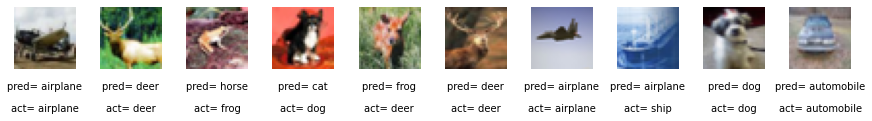

In [11]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)),n_to_show)

fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax= fig.add_subplot(1,n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5,-0.35,'pred= ' +str(preds_single[idx]),fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5,-0.7,'act= ' +str(actual_single[idx]),fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img)

# 2.4 모델 성능 향상

앞선 네트워크가 더 높은 성능을 내지 못하는 한 가지 이유는 입력 이미지의 공간 구조를 다룰 수 있는 요소가 네트워크에 없기 때문이다.
우리는 첫 번째 Dense층에 전달하기 위해 첫 단계에서 이미지를 하나의 벡터로 펼쳤다.

=> 이를 해결하기 위해 합성곱 층을 사용해야 한다.

## 2.4.1 합성곱 층 

합성곱은 필터를 이미지의 일부분과 픽셀끼리 곱한 후 결과를 더하는 것이다.

In [12]:
from keras.layers import Conv2D

input_layer = Input(shape=(64,64,1))

conv_layer_1 = Conv2D(filters = 2, kernel_size = (3,3), strides = 1, padding = 'same')(input_layer)

In [13]:
# CIFAR-10 데이터셋에 Conv2D층 적용하기

input_layer = Input(shape=(32,32,3))

conv_layer_1 = Conv2D(filters = 10, kernel_size = (4,4), strides = 2, padding='same')(input_layer)
conv_layer_2 = Conv2D(filters = 20, kernel_size = (3,3), strides = 2, padding='same')(conv_layer_1)

flatten_layer = Flatten()(conv_layer_2)
output_layer = Dense(units=10,activation='softmax')(flatten_layer)

model = Model(input_layer,output_layer)

In [14]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 10)        490       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 20)          1820      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                12810     
Total params: 15,120
Trainable params: 15,120
Non-trainable params: 0
_________________________________________________________________


## 2.4.2 배치 정규화 층

심층 신경망을 훈련할 때 대표적으로 어려운 한 가지는 네트워크의 가중치를 일정한 범위 안에서 유지해야 한다는 것이다.
값이 커지기 시작한다면 네트워크에 **그레이디언트 폭주(gradient exploding)** 문제가 발생했다는 신호이다.
우선, 그레이디언트 폭주 문제에 대한 근본적인 원인을 이해해야한다.
- 신경망에 주입되는 입력 데이터 스케일 조정 => 스케일이 조정되지 않은 입력은 큰 활성화 출력을 만들어 그레이디언트 폭주로 이어질 가능성이 있다. 따라서 입력 층으로 0 ~ 255 사이의 픽셀값을 전달하는 대신 -1 ~ 1사이의 값으로 스케일을 바꾼다.


입력 스케일을 조정했기 때문에 모든 층의 활성화 출력도 비교적 스케일이 안정될것으로 기대할 수 있지만 네트워크가 훈련됨에 따라 가중치 값이 랜덤한 초깃값과 멀어지기 때문에 이런 가정이 무너지기 시작한다.
=> 이런 현상을 **공변량 변화**라고 부른다.

**배치 정규화(batch normalization)은 이 문제를 극적으로 감소시키는 솔루션이다.**
- 배치 정규화 층은 배치에 대해 각 입력 채널별로 평균과 표준 편차를 계산한 다음 평균을 빼고 표준 편차로 나누어 정규화
- 배치 정규화 층을 완전 연결 층이나 합성곱 층 직후에 두어 층의 출력을 정규화
- 테스트할 때는 하나의 샘플에 대해 예측을 만들기 때문에 평균을 계산할 배치가 없음 => 훈련과정에서 배치 정규화 층이 채널별로 평균과 표준 편차의 이동평균(moving average)을 계산하여 저장하여 테스트를 할 때 이 값을 사용하여 입력을 정규화한다.

BatchNormalization(momentum = 0.9)      # momentum 매개변수는 평균과 표준 편차의 이동평균을 계산할 때 이전 값에 주는 가중치

## 2.4.3 드롭아웃 층

알고리즘이 훈련 데이터셋에만 잘 동작하고 테스트 세트에서는 그렇지 않다면 **과대적합(overfitting)** 문제가 있다고 말한다.

=> 이 문제에 대응하려면 규제(regularization)기법을 사용하여 모델이 과대 적합 되는 것에 벌칙을 부여

머신러닝 알고리즘에 규제를 가하는 여러 가지 방법이 있지만 딥러닝에서 가장 널리 사용하는 것은 **드롭아웃(dropout)층** 이다.

- 드롭아웃 층은 훈련과정에서 이전 층의 유닛 일부를 랜덤하게 선택하여 출력을 0으로 지정한다.
- 테스트할 때는 드롭아웃 층이 어떤 유닛도 드롭하지 않고 전체 네트워크를 사용하여 예측을 만든다.
- dropout 층은 가중치 개수가 많아 과대 적합되기 가장 쉬운 Dense층 다음에 주로 사용된다.

Dropout(rate=0.25)  # rate 매개변수는 이전 층에서 드롭아웃 할 유닛의 비율을 지정

## 2.4.4 합성곱, 배치 정규화, 드롭아웃 적용하기

새로운 딥러닝 모델을 만들고 CIFAR-10 데이터셋에서 성능을 확인해본다.

In [23]:
from keras.layers import BatchNormalization,LeakyReLU,Dropout,Activation

input_layer = Input((32,32,3))

x = Conv2D(filters=32, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x=Flatten()(x)

x=Dense(128)(x)
x = BatchNormalization()(x)
x=LeakyReLU()(x)
x= Dropout(rate =0.5)(x)

x= Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)
model = Model(input_layer, output_layer)

In [25]:
from keras.optimizers import Adam

opt=Adam(lr=0.0005) # 옵티마이저 - 손실 함수의 그레이디언트를 기반으로 신경망의 가중치를 업데이트 하기 위해 사용하는 알고리즘
# 가장 많이 사용하는 세 개의 손실함수는 평균제곱오차, 범주형 크로스 엔트로피, 이진 크로스 엔트로피 이다.
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy']) #  metrics로 훈련과정에서 기록하고 싶은 지표 지정가능

In [26]:
# batch_size는 훈련 스텝마다 네트워크에 전달될 샘플의 개수, shuffle  = True는 훈련 스텝마다 배치를 훈련 데이터에서 중복 허용하지 않고 랜덤하게 추출
model.fit(x_train, y_train, batch_size = 32, epochs = 10, shuffle = True)

Epoch 1/10
50000/50000 [==============================] - 292s 6ms/step - loss: 1.5468 - accuracy: 0.4590
Epoch 2/10
50000/50000 [==============================] - 349s 7ms/step - loss: 1.1300 - accuracy: 0.6047
Epoch 3/10
50000/50000 [==============================] - 331s 7ms/step - loss: 0.9969 - accuracy: 0.6527
Epoch 4/10
50000/50000 [==============================] - 357s 7ms/step - loss: 0.9118 - accuracy: 0.6831
Epoch 5/10
50000/50000 [==============================] - 322s 6ms/step - loss: 0.8486 - accuracy: 0.7021
Epoch 6/10
50000/50000 [==============================] - 298s 6ms/step - loss: 0.7991 - accuracy: 0.7211
Epoch 7/10
50000/50000 [==============================] - 285s 6ms/step - loss: 0.7559 - accuracy: 0.7348
Epoch 8/10
50000/50000 [==============================] - 280s 6ms/step - loss: 0.7161 - accuracy: 0.7497
Epoch 9/10
50000/50000 [==============================] - 287s 6ms/step - loss: 0.6837 - accuracy: 0.7598
Epoch 10/10
50000/50000 [=====================

In [27]:
# 성능확인
model.evaluate(x_test,y_test, batch_size=1000)

10000/10000 [==============================] - 10s 1ms/step


[0.7979714751243592, 0.7232000231742859]